In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score 
import lightgbm as lgb

In [3]:
df=pd.read_csv('../data/processed_company_data.csv', encoding='utf-8' )
df.shape

(196553, 54)

In [6]:
target= 'success_label'
train_df,test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[target])
print("Train size:", train_df.shape)
print("Test size:", test_df.shape)
print(train_df['success_label'].value_counts())
print(test_df['success_label'].value_counts())

Train size: (157242, 54)
Test size: (39311, 54)
success_label
0    135529
1     21713
Name: count, dtype: int64
success_label
0    33883
1     5428
Name: count, dtype: int64


In [7]:
numeric_features = [
    "total_funding",
    "funding_rounds",
    "milestones",
    "relationships",
    "company_age_years",
    "time_to_first_funding_days",
    "log1p_total_funding",
    "log1p_funding_rounds",
    "log1p_milestones",
    "log1p_relationships",
]
numeric_features = [f for f in numeric_features if f in df.columns]
print("Numeric features used:", numeric_features)

Numeric features used: ['total_funding', 'funding_rounds', 'milestones', 'relationships', 'company_age_years', 'time_to_first_funding_days', 'log1p_total_funding', 'log1p_funding_rounds', 'log1p_milestones', 'log1p_relationships']


In [8]:

X_train_num = train_df[numeric_features]
X_test_num = test_df[numeric_features]
y_train = train_df[target]
y_test = test_df[target]

In [9]:
train_lgb=lgb.Dataset(X_train_num, label=y_train)
test_lgb=lgb.Dataset(X_test_num, label=y_test, reference=train_lgb)

In [13]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}
model_lgb=lgb.train(params,
                    train_lgb,num_boost_round=100,
                    valid_sets=[train_lgb, test_lgb])
y_pred_prob = model_lgb.predict(X_test_num, num_iteration=model_lgb.best_iteration)
y_pred = (y_pred_prob >= 0.5).astype(int)
auc = roc_auc_score(y_test, y_pred_prob)
print("ROC AUC Score:", auc)

ROC AUC Score: 0.9351036531037241


In [19]:
print("\nClassification Report (Text Baseline):")
print(classification_report(y_test, (y_pred > 0.5).astype(int)))


Classification Report (Text Baseline):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     33883
           1       0.99      0.71      0.83      5428

    accuracy                           0.96     39311
   macro avg       0.97      0.85      0.90     39311
weighted avg       0.96      0.96      0.96     39311



In [14]:
importance_df=pd.DataFrame({'feature':numeric_features,'importance':model_lgb.feature_importance()}).sort_values('importance',ascending=False)
importance_df.head()

,feature,importance
4,company_age_years,893
3,relationships,535
2,milestones,424
5,time_to_first_funding_days,355
0,total_funding,265


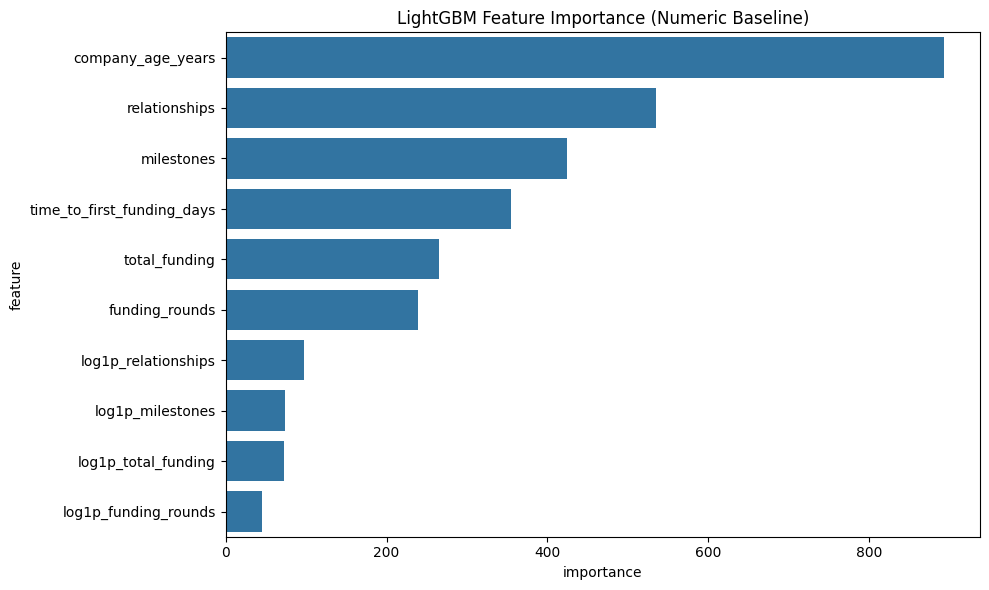

In [18]:
plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title("LightGBM Feature Importance (Numeric Baseline)")
plt.tight_layout()
plt.savefig("../plots/feature_importance_numeric.png")
plt.show()

In [17]:

joblib.dump(model_lgb, "../models/lightgbm_baseline_numeric.pkl")
print("Model Saved")

Model Saved
